In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv
/kaggle/input/redditmh/processed_disorders.csv


In [2]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary
import tensorflow as tf
import keras
from keras import layers, optimizers

# Data Processing

In [3]:
data = pd.read_csv("/kaggle/input/redditmh/processed_disorders.csv")
data.head()

,content,label
0,life is so pointless without others : does any...,bpd
1,cold rage : hello fellow friends \n\ni'm on th...,bpd
2,i dont know who i am : my f20 bf m20 told me t...,bpd
3,"help opinions advice : okay, im about to open ...",bpd
4,my ex got diagnosed with bpd : without going i...,bpd


In [4]:
data = data.rename(columns = {"content":"text"})
data

,text,label
0,life is so pointless without others : does any...,bpd
1,cold rage : hello fellow friends \n\ni'm on th...,bpd
2,i dont know who i am : my f20 bf m20 told me t...,bpd
3,"help opinions advice : okay, im about to open ...",bpd
4,my ex got diagnosed with bpd : without going i...,bpd
...,...,...
543055,jaw clenching : hey. i don't know if this is t...,schizophrenia
543056,is it safe to take appetite suppressants for w...,schizophrenia
543057,i'm worried i can't tell what side effects i a...,schizophrenia
543058,and the symptoms are back : was getting the sk...,schizophrenia


In [5]:
data['label'].unique()

array(['bpd', 'bipolar', 'depression', 'anxiety', 'schizophrenia'],
      dtype=object)

In [6]:
from sklearn.preprocessing import OrdinalEncoder
encode = OrdinalEncoder()
data['label'] = encode.fit_transform(data['label'].values.reshape(-1, 1)).astype(int)
data['label'].unique()

array([2, 1, 3, 0, 4])

In [7]:
data.isnull().any()

text     False
label    False
dtype: bool

In [8]:
data = data.dropna(axis = 0)
data

,text,label
0,life is so pointless without others : does any...,2
1,cold rage : hello fellow friends \n\ni'm on th...,2
2,i dont know who i am : my f20 bf m20 told me t...,2
3,"help opinions advice : okay, im about to open ...",2
4,my ex got diagnosed with bpd : without going i...,2
...,...,...
543055,jaw clenching : hey. i don't know if this is t...,4
543056,is it safe to take appetite suppressants for w...,4
543057,i'm worried i can't tell what side effects i a...,4
543058,and the symptoms are back : was getting the sk...,4


In [9]:
data.isnull().any()

text     False
label    False
dtype: bool

In [10]:
from sklearn.model_selection import train_test_split
train_df, other = train_test_split(
    data,
    test_size = 0.2,
    random_state = 9700,
    shuffle = True,
    stratify = data['label'],
)

In [11]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9700,
    shuffle = True,
    stratify = other['label'],
)

In [12]:
len(train_df), len(val_df) ,len(test_df)

(434448, 54306, 54306)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [48]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [15]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [16]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b"i am other peoples trauma and i can't deal with it. : i saw someone today that i hadn't seen in 10 years. we knew each other in high school when my symptoms really started to show themselves. i saw her at the grocery store with her two kids and as soon as she saw me she left her buggy and bolted from the store. i don't think i'm the only person here who has done and said terrible things that they're ashamed of but i never thought i had, i don't know, such a strong effect. \n\n\n\nit's been 2 years since i was last ghosted by my fp, as y'all say, and i've been on my own since as i don't want to trust anyone anymore. this year has been particularly brutal with multiple people and animals around me dying under horrible circumstances. the levees finally broke and i hurt myself like a minute after making it back to the house. the shame of being 30 and cutting again combined with not being able to stop thinking about the fucked up things i did as a teen and the people i did them to is comp

In [17]:
reserved_tokens = ["[PAD]", "[UNK]"]

#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

414336


In [18]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [20]:
with tf.device('/GPU:0'):
    vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [21]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [22]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b"i am other peoples trauma and i can't deal with it. : i saw someone today that i hadn't seen in 10 years. we knew each other in high school when my symptoms really started to show themselves. i saw her at the grocery store with her two kids and as soon as she saw me she left her buggy and bolted from the store. i don't think i'm the only person here who has done and said terrible things that they're ashamed of but i never thought i had, i don't know, such a strong effect. \n\n\n\nit's been 2 years since i was last ghosted by my fp, as y'all say, and i've been on my own since as i don't want to trust anyone anymore. this year has been particularly brutal with multiple people and animals around me dying under horrible circumstances. the levees finally broke and i hurt myself like a minute after making it back to the house. the shame of being 30 and cutting again combined with not being able to stop thinking about the fucked up things i did as a teen and the people 

In [23]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [51]:
from keras_hub.layers import TokenAndPositionEmbedding
import keras_tuner as kt
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)
        return context_vector, attention_weights

# Define ExpandDims Layer
class ExpandDimsLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Define Model Function
def EmoAkinator():
    # Input layer
    input_ids = Input(shape=(MAX_SEQLEN,), dtype="int64", name="input_ids")
    
    # Token and Position Embedding
    x = TokenAndPositionEmbedding(
        vocabulary_size=414336,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=False,
    )(input_ids)
    
    # Bidirectional LSTM with regularization
    x = Bidirectional(
        LSTM(
            64, 
            activation="tanh", 
            return_sequences=True,  # Needed for AttentionLayer
            kernel_regularizer=regularizers.l2(0.001),
        )
    )(x)
    
    # First Attention Layer
    context_vector_1, attention_weights_1 = AttentionLayer()(x)
    
    # Expand dimensions for another attention layer
    context_vector_1_expanded = ExpandDimsLayer(axis=1)(context_vector_1)
    
    # Second Attention Layer
    context_vector_2, attention_weights_2 = AttentionLayer()(context_vector_1_expanded)
    
    # Final Dense Layer
    output = Dense(5, activation="softmax")(context_vector_2)
    
    # Compile the model
    model = Model(input_ids, output, name="EmoAkinator")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=3e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [52]:
EmoAkinator6= EmoAkinator()
EmoAkinator6.summary()

Model: "EmoAkinator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_8       │ (None, 512, 128)            │      53,100,544 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 512, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_6 (AttentionLayer)   │ [(None, 128), (None, 512,   │          16,640 │
│                                      │ 1)]                         │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dims_layer_5                  │ (None, 1, 128)              │               0 │
│ (ExpandDimsLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_7 (AttentionLayer)   │ [(None, 128), (None, 1, 1)] │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,233,285 (203.07 MB)

 Trainable params: 53,233,285 (203.07 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
for inputs, targets in train_dataset.take(1):
    input_ids = inputs["input_ids"]
    break
embedding_layer = EmoAkinator6.layers[1]
mask = embedding_layer.compute_mask(input_ids)
print("Computed mask:", mask)

Computed mask: None


In [55]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0973,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 0,
)
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 5,
    verbose = 2,
    mode = "auto",
    restore_best_weights = True,
)
ck_point = keras.callbacks.ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)
history = EmoAkinator6.fit(
    train_dataset,
    epochs=10, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR, ck_point]
)

Epoch 1/10
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7934 - loss: 0.6316
Epoch 1: val_loss improved from inf to 0.50813, saving model to best_model.keras
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 490s 72ms/step - accuracy: 0.7934 - loss: 0.6316 - val_accuracy: 0.8257 - val_loss: 0.5081 - learning_rate: 3.0000e-04
Epoch 2/10
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8407 - loss: 0.4774
Epoch 2: val_loss improved from 0.50813 to 0.47608, saving model to best_model.keras
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 479s 71ms/step - accuracy: 0.8407 - loss: 0.4774 - val_accuracy: 0.8353 - val_loss: 0.4761 - learning_rate: 3.0000e-04
Epoch 3/10
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8520 - loss: 0.4351
Epoch 3: val_loss improved from 0.47608 to 0.47038, saving model to best_model.keras
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 480s 71ms/step - accuracy: 0.8520 - loss: 0.4351 - val_accuracy: 0.8366 - val_loss: 0.4704 - learning_rate: 3.0000e-04
Epoch 4/10
6789/6789 ━━━━━━━━━━━

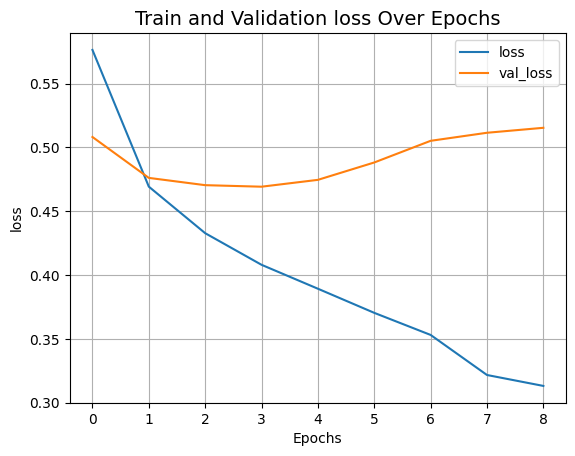

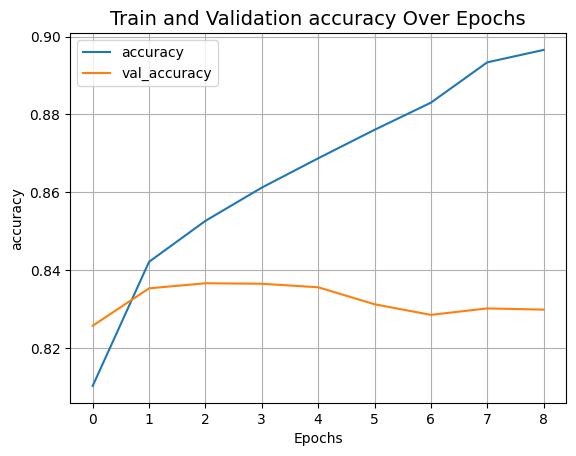

In [59]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [58]:
EmoAkinator6.evaluate(test_dataset)

849/849 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8379 - loss: 0.4676


[0.4646100103855133, 0.8395389318466187]